In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.stats as sps
import json, pickle, os, corner, glob
import enterprise.signals.utils as utils
from enterprise.pulsar import Pulsar
import arviz as az
from collections import defaultdict


import warnings
warnings.filterwarnings('ignore')

In [3]:
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec
from la_forge.utils import epoch_ave_resid

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index("akaiser")
#top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

In [5]:
psr_name = 'J1640+2224'#'J1640+2224'#'J2317+1439' 'J1909-3744'

num_chains = 1

psrlist = [psr_name]
datareleases = ['5yr','9yr']

datadir_list = []
parfiles = []
timfiles = []
for datarelease in datareleases:
    datadir = top_dir + '/{}'.format(datarelease)
    tmp_parfiles = sorted(glob.glob(datadir + '/par/*.par'))
    tmp_timfiles = sorted(glob.glob(datadir + '/tim/*.tim'))
    # filter
    parfiles = np.concatenate((parfiles,[x for x in tmp_parfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]),axis=0)
    timfiles = np.concatenate((timfiles,[x for x in tmp_timfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]),axis=0)

psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem='DE436', clk=None, drop_t2pulsar=False)
    psrs.append(psr)
    
for psr in psrs:
    print(psr.name)
    
pardict = {}
for psr in psrs:
    pardict[psr.name] = {}
    for par,vals,errs in zip(psr.fitpars[1:],psr.t2pulsar.vals(),psr.t2pulsar.errs()):
        if "DMX" in ["".join(list(x)[0:3]) for x in par.split("_")][0]:
            pass
        elif "JUMP" in ["".join(list(x)[0:4]) for x in par.split("_")][0]:
            pass
        elif par == "Offset":
            pass
        elif par in ["RAJ", "DECJ", "ELONG", "ELAT", "BETA", "LAMBDA"]:
            pass
        elif par in ["PMRA", "PMDEC", "PMELONG", "PMELAT", "PMBETA", "PMLAMBDA"]:
            pass
        else:
            pardict[psr.name][par] = {}
            pardict[psr.name][par]['val'] = vals
            pardict[psr.name][par]['err'] = errs

1640+2224
J1640+2224


In [6]:
def rescale_pars(chains,tmparams,pardict):
    if not isinstance(chains,np.ndarray):
        chains=np.array(chains)
    if chains.ndim != 3:
        chains=np.array([chains])
    if not isinstance(tmparams,np.ndarray):
        tmparams=np.array(tmparams)
    if tmparams.ndim != 2:
        tmparams=np.array([tmparams])

    print(chains.shape)
    print(tmparams.shape)
    rescaled_chain_dict = {}
    for i in range(np.shape(tmparams)[0]):
        for j,par in enumerate(tmparams[i]):
            split_string = par.split('_')
            psr_name = split_string[0]
            if 'kep' in split_string:
                if '0' in split_string or 'PB' in split_string:
                    og_par = 'PB'
                elif '1' in split_string or 'T0' in split_string:
                    og_par = 'T0'
                elif '2' in split_string or 'A1' in split_string:
                    og_par = 'A1'
                elif '3' in split_string or 'OM' in split_string:
                    og_par = 'OM'
                elif '4' in split_string or 'ECC' in split_string:
                    og_par = 'ECC'
                elif '5' in split_string or 'M2' in split_string:
                    og_par = 'M2'
                else:
                    og_par = 'GOAWAY'

                if og_par != 'GOAWAY':
                    rescaled_chain = chains[i][:,j]*pardict[psr_name][og_par]['err']+pardict[psr_name][og_par]['val']
                else:
                    raise ValueError('Something went wrong.')

            elif 'spin' in split_string:
                if '0' in split_string or 'F0' in split_string:
                    og_par = 'F0'
                elif '1' in split_string or 'F1' in split_string:
                    og_par = 'F1'
                else:
                    og_par = 'GOAWAY'

                if og_par != 'GOAWAY':
                    rescaled_chain = chains[i][:,j]*pardict[psr_name][og_par]['err']+pardict[psr_name][og_par]['val']
                else:
                    raise ValueError('Something went wrong.')

            else:
                if psr_name in ['lnlike','lnprior', 'chain accept', 'pt chain accept']:
                    og_par = par
                else:
                    if list(par)[0] != 'J':
                        og_par = 'J' + par
                    else:
                        og_par = par
                rescaled_chain = chains[i][:,j]

            if og_par in rescaled_chain_dict.keys():
                rescaled_chain_dict[og_par] = np.concatenate((rescaled_chain_dict[og_par],[rescaled_chain]),axis=0)
            else:
                rescaled_chain_dict[og_par] = [rescaled_chain]
            
    return rescaled_chain_dict

In [7]:
chaindir_list = []
indices = np.arange(1,6,1)
print(indices)
#big_chaindir = os.getcwd()+'/chains/{}_all_var'.format(psr)
for i in indices:
    for datarelease in datareleases:
        #chaindir_list.append(os.getcwd()+'/chains/{}/{}_all_var_{}'.format(datarelease,psr,i))
        if i in [1,2]:
            chaindir_list.append(os.getcwd()+'/chains/{}/{}_testing_uniform_tm_{}'.format(datarelease,psr_name,i))
            if datarelease == '5yr':
                chaindir_list.append(os.getcwd()+'/chains/{}/{}_testing_bounded_normal_tm_{}'.format(datarelease,psr_name,i))
            else:
                pass
        elif i in [3,4]:
            chaindir_list.append(os.getcwd()+'/chains/{}/{}_testing_uniform_tm_{}'.format(datarelease,psr_name,i))
        elif i in [5]:
            if datarelease == '5yr':
                chaindir_list.append(os.getcwd()+'/chains/{}/{}_testing_timing_2_uniform_1'.format(datarelease,psr_name))
            else:
                pass
[print(chaindir) for chaindir in chaindir_list];

[1 2 3 4 5]
/hyrule/data/users/akaiser/enterprise_timing/chains/5yr/J1640+2224_testing_uniform_tm_1
/hyrule/data/users/akaiser/enterprise_timing/chains/5yr/J1640+2224_testing_bounded_normal_tm_1
/hyrule/data/users/akaiser/enterprise_timing/chains/9yr/J1640+2224_testing_uniform_tm_1
/hyrule/data/users/akaiser/enterprise_timing/chains/5yr/J1640+2224_testing_uniform_tm_2
/hyrule/data/users/akaiser/enterprise_timing/chains/5yr/J1640+2224_testing_bounded_normal_tm_2
/hyrule/data/users/akaiser/enterprise_timing/chains/9yr/J1640+2224_testing_uniform_tm_2
/hyrule/data/users/akaiser/enterprise_timing/chains/5yr/J1640+2224_testing_uniform_tm_3
/hyrule/data/users/akaiser/enterprise_timing/chains/9yr/J1640+2224_testing_uniform_tm_3
/hyrule/data/users/akaiser/enterprise_timing/chains/5yr/J1640+2224_testing_uniform_tm_4
/hyrule/data/users/akaiser/enterprise_timing/chains/9yr/J1640+2224_testing_uniform_tm_4
/hyrule/data/users/akaiser/enterprise_timing/chains/5yr/J1640+2224_testing_timing_2_uniform_1


In [8]:
chaindir_indices = {}
chaindir_indices['uniform'] = defaultdict(list)
chaindir_indices['bounded'] = defaultdict(list)
chaindir_indices['misc'] = defaultdict(list)
for i,chaindir in enumerate(chaindir_list):
    sep = chaindir.split('/')
    dataset = sep[7]
    name = sep[-1]
    if 'uniform' in name.split('_') and not 'timing' in name.split('_'):
        chaindir_indices['uniform'][dataset].append(i)
    elif 'bounded' in name.split('_'):
        chaindir_indices['bounded'][dataset].append(i)
    else:
        chaindir_indices['misc'][dataset].append(i)

In [9]:
chain_list = []
tmparam_list = []
for chaindir in chaindir_list:
    tmp_tmparam = []
    tmp_tmparam.extend(np.loadtxt(chaindir + '/pars.txt',dtype='S').astype('U'))
    tmp_tmparam.extend(('lnlike','lnprior', 'chain accept', 'pt chain accept'))
    tmparam_list.append(tmp_tmparam)
    chain = np.loadtxt(chaindir + '/chain_1.txt')
    burn = int(0.25 * chain.shape[0])
    chain_list.append(chain[burn:])

In [10]:
for chain in chain_list:
    print(np.shape(chain))

(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)


In [11]:
core_list = []
for chaindir in chaindir_list:
    core_list.append(co.Core(label='_'.join(chaindir.split('/')[-2:]), chaindir=chaindir))

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 24975
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 24975
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 24975
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Ple

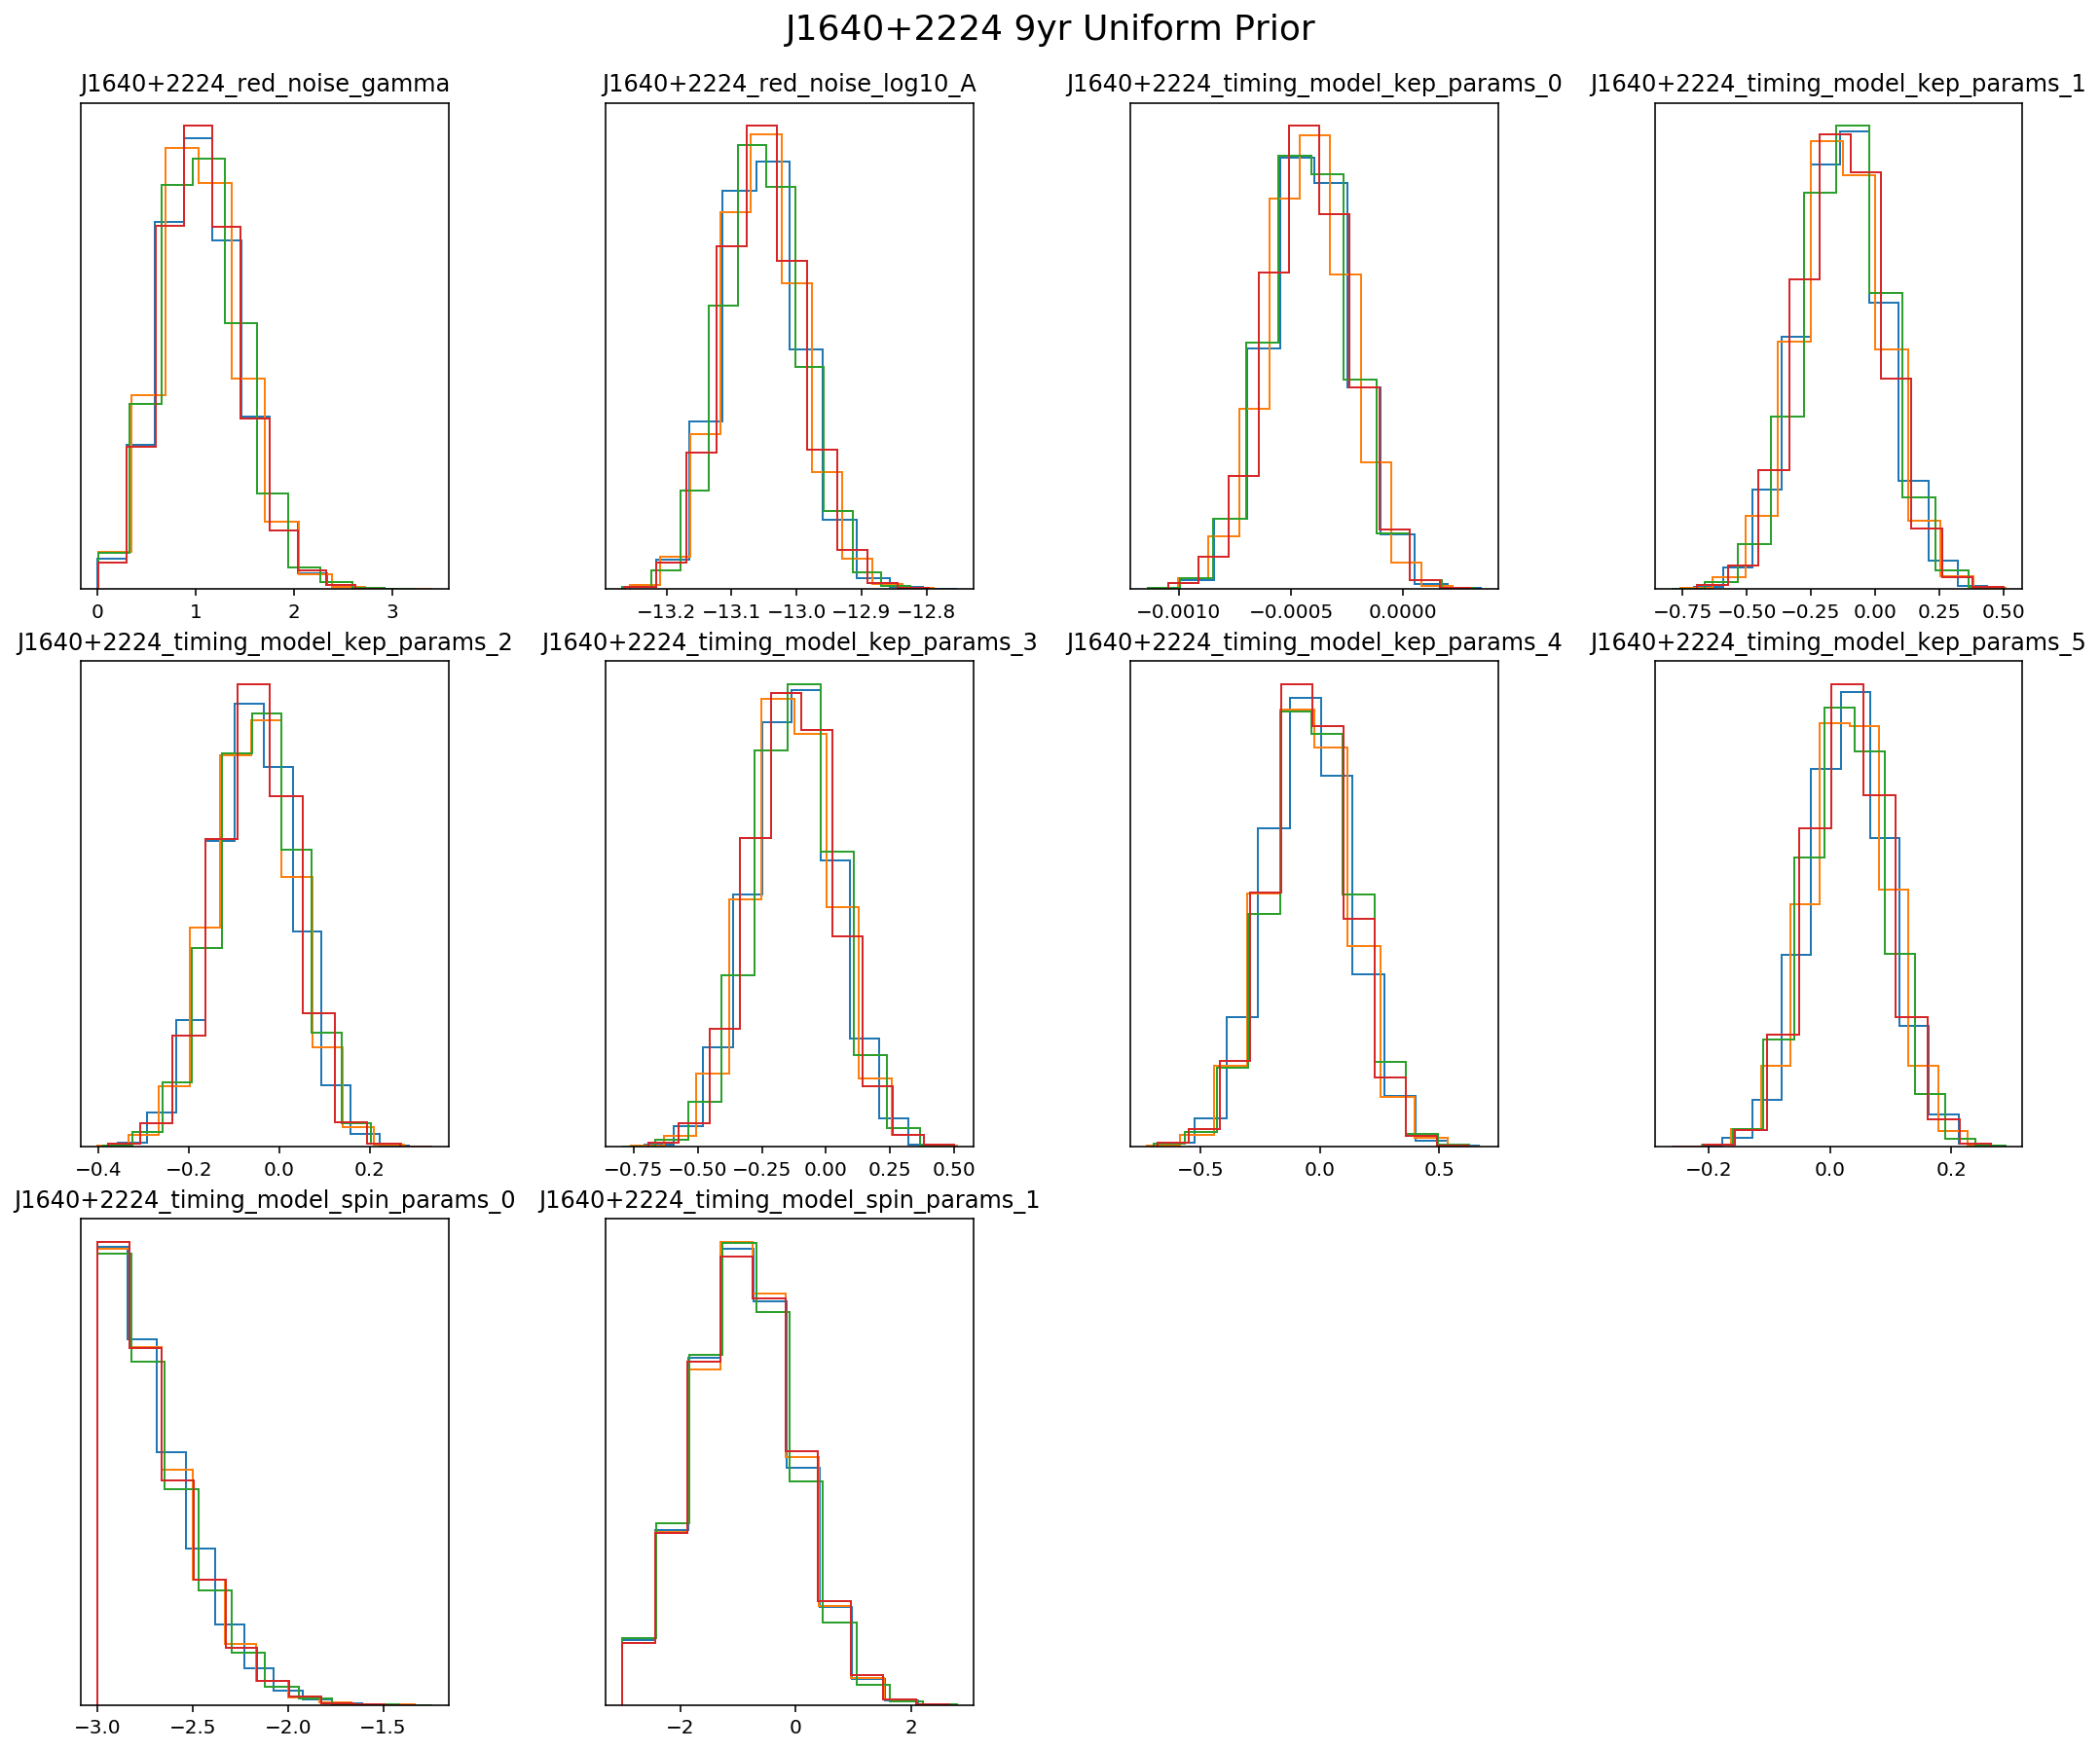

In [12]:
common_pars = []
for param in core_list[chaindir_indices['uniform']['9yr'][0]].params:
    if param not in ['lnlike','lnprior', 'chain_accept', 'pt_chain_accept']:
        common_pars.append(param)
dg.plot_chains([core_list[x] for x in chaindir_indices['uniform']['9yr']],
               pars=common_pars, hist=True, ncols=4, title_y=1.03,
               suptitle='J1640+2224 9yr Uniform Prior',
               bins=10,hist_kwargs=dict(fill=False))

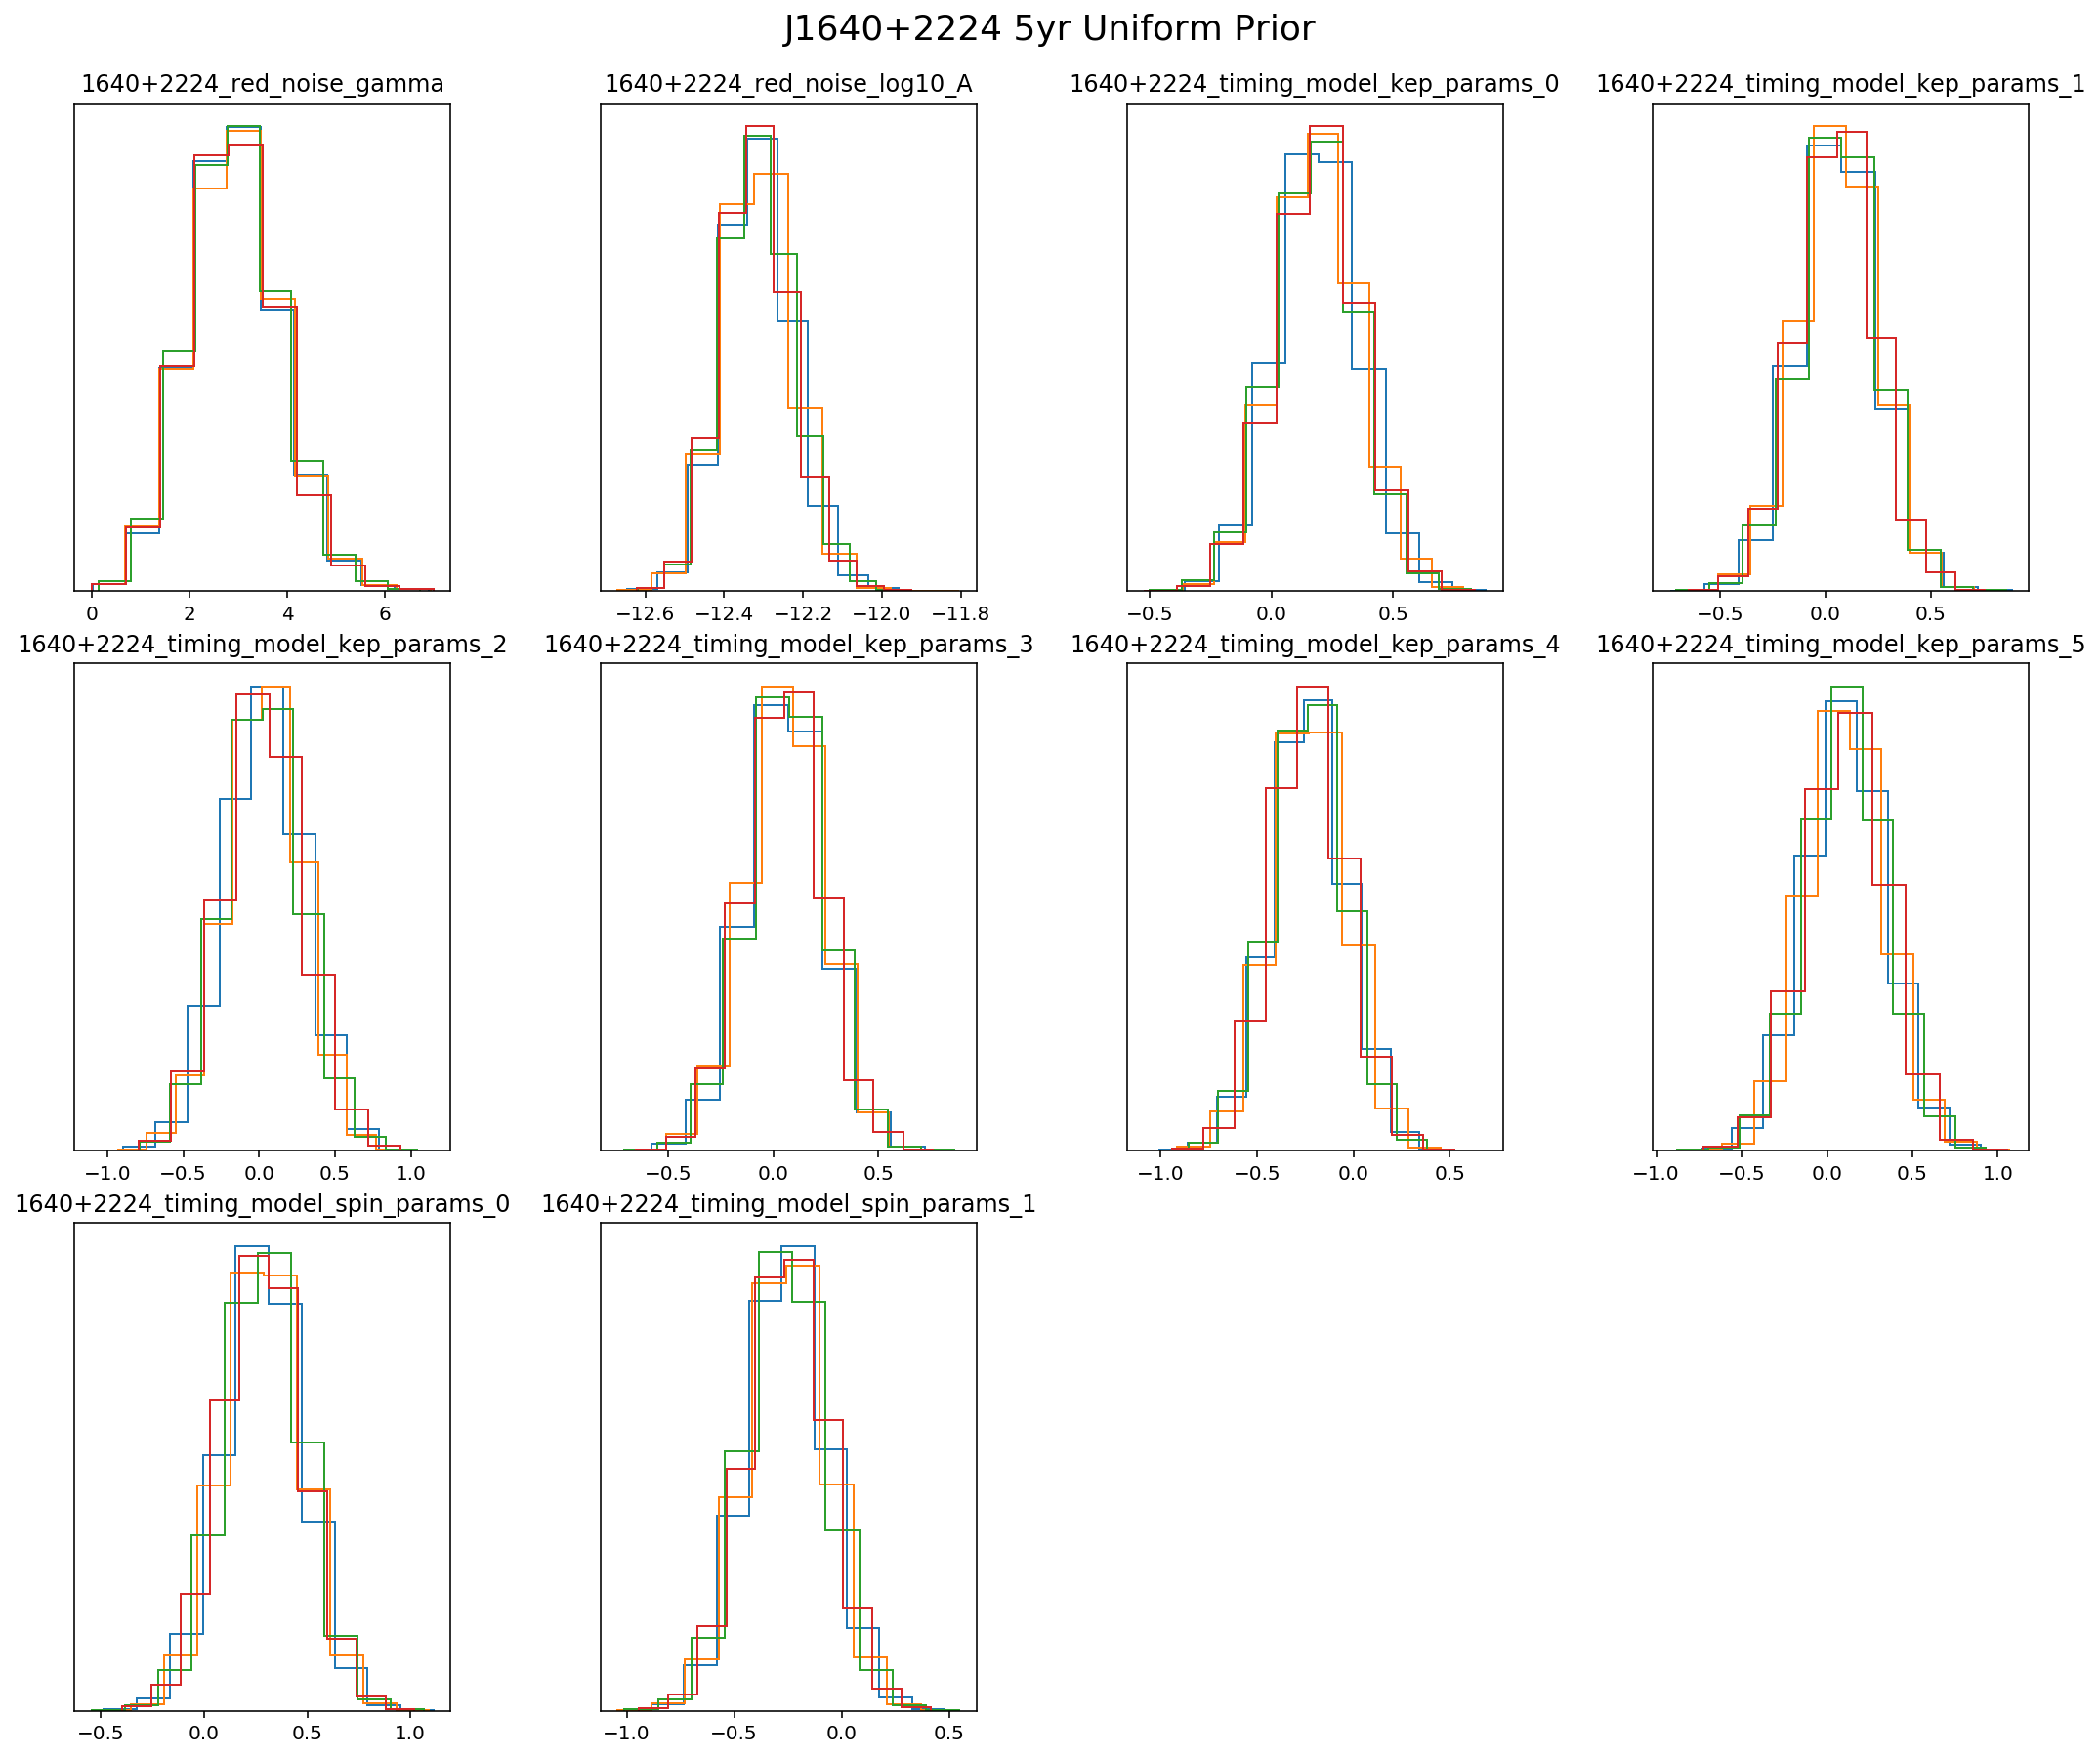

In [13]:
common_pars = []
for param in core_list[chaindir_indices['uniform']['5yr'][0]].params:
    if param not in ['lnlike','lnprior', 'chain_accept', 'pt_chain_accept']:
        common_pars.append(param)
dg.plot_chains([core_list[x] for x in chaindir_indices['uniform']['5yr']],
               pars=common_pars, hist=True, ncols=4, title_y=1.03,
               suptitle='J1640+2224 5yr Uniform Prior',
               bins=10,hist_kwargs=dict(fill=False))

In [16]:
"""common_pars = []
print(chaindir_indices['bounded']['9yr'])
for param in core_list[chaindir_indices['bounded']['9yr'][0]].params:
    if param not in ['lnlike','lnprior', 'chain_accept', 'pt_chain_accept']:
        common_pars.append(param)
dg.plot_chains([core_list[x] for x in chaindir_indices['bounded']['9yr']],
               pars=common_pars, hist=True, ncols=4, title_y=1.03,
               suptitle='J1640+2224 9yr Bounded Normal Prior',
               bins=10,hist_kwargs=dict(fill=False))"""

"common_pars = []\nprint(chaindir_indices['bounded']['9yr'])\nfor param in core_list[chaindir_indices['bounded']['9yr'][0]].params:\n    if param not in ['lnlike','lnprior', 'chain_accept', 'pt_chain_accept']:\n        common_pars.append(param)\ndg.plot_chains([core_list[x] for x in chaindir_indices['bounded']['9yr']],\n               pars=common_pars, hist=True, ncols=4, title_y=1.03,\n               suptitle='J1640+2224 9yr Bounded Normal Prior',\n               bins=10,hist_kwargs=dict(fill=False))"

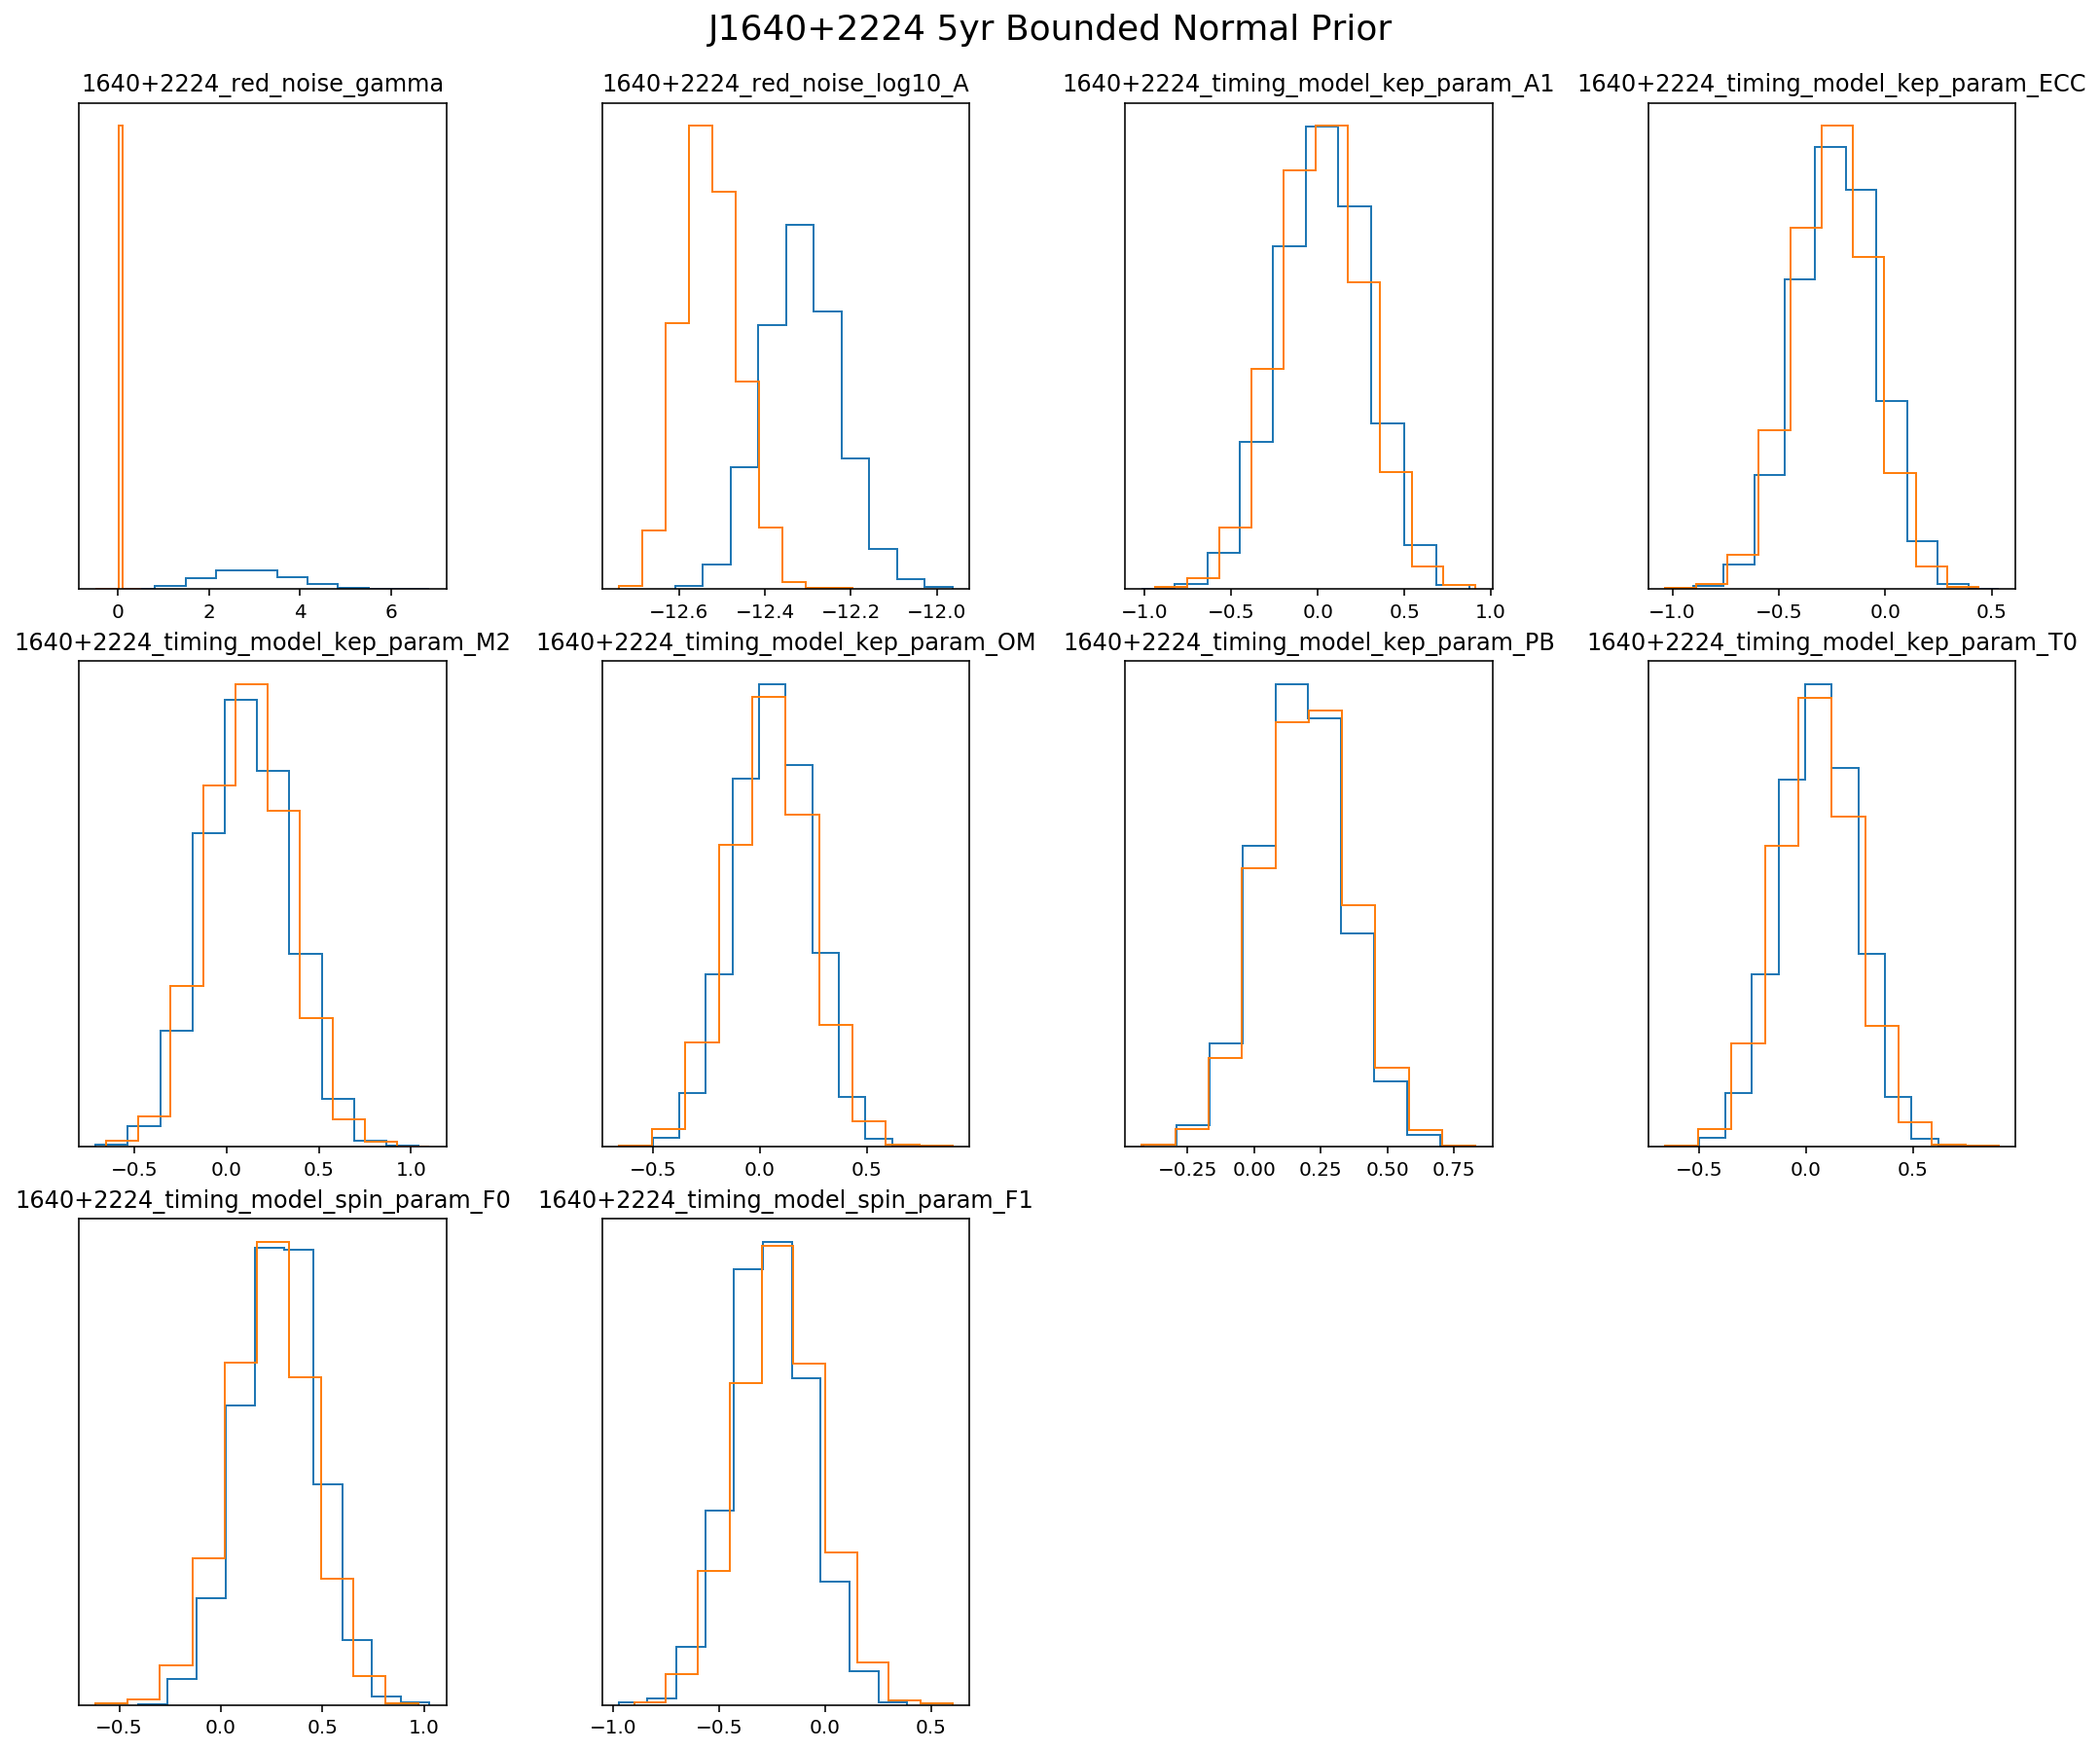

In [17]:
common_pars = []
for param in core_list[chaindir_indices['bounded']['5yr'][0]].params:
    if param not in ['lnlike','lnprior', 'chain_accept', 'pt_chain_accept']:
        common_pars.append(param)
dg.plot_chains([core_list[x] for x in chaindir_indices['bounded']['5yr']],
               pars=common_pars, hist=True, ncols=4, title_y=1.03,
               suptitle='J1640+2224 5yr Bounded Normal Prior',
               bins=10,hist_kwargs=dict(fill=False))

In [18]:
chain_dict = {}
#indices = np.arange(8,16,1)
indices = np.array(range(len(chain_list)))
for i in indices:
    tmpchain = chain_list[i]
    print(np.shape(tmpchain))
    for j,par in enumerate(tmparam_list[i]):
        if par.split('_')[0] in [psr.name for psr in psrs]: 
            if list(par)[0] != 'J':
                par = 'J' + par
        if par in chain_dict.keys():
            chain_dict[par] = np.concatenate((chain_dict[par],[tmpchain[:,j]]),axis=0)
        else:
            chain_dict[par] = [tmpchain[:,j]]
az_comb = az.convert_to_inference_data(chain_dict)

(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)
(74925, 14)


In [19]:
print(az_comb.posterior)

<xarray.Dataset>
Dimensions:                                (chain: 11, draw: 74925)
Coordinates:
  * chain                                  (chain) int64 0 1 2 3 4 5 6 7 8 9 10
  * draw                                   (draw) int64 0 1 2 ... 74923 74924
Data variables:
    J1640+2224_red_noise_gamma             (chain, draw) float64 3.061 ... 2.546
    J1640+2224_red_noise_log10_A           (chain, draw) float64 -12.36 ... -12.33
    J1640+2224_timing_model_kep_params_0   (chain, draw) float64 -0.1223 ... nan
    J1640+2224_timing_model_kep_params_1   (chain, draw) float64 0.1922 ... nan
    J1640+2224_timing_model_kep_params_2   (chain, draw) float64 0.1587 ... nan
    J1640+2224_timing_model_kep_params_3   (chain, draw) float64 0.1918 ... nan
    J1640+2224_timing_model_kep_params_4   (chain, draw) float64 -0.418 ... nan
    J1640+2224_timing_model_kep_params_5   (chain, draw) float64 0.1088 ... nan
    J1640+2224_timing_model_spin_params_0  (chain, draw) float64 0.2171 ... nan
   

In [20]:
az.summary(az_comb)

mean         sd    hpd_3%  \
J1640+2224_red_noise_gamma                 1.985      1.290     0.016   
J1640+2224_red_noise_log10_A             -12.601      0.354   -13.143   
J1640+2224_timing_model_kep_params_0         NaN        NaN    -0.522   
J1640+2224_timing_model_kep_params_1         NaN        NaN    -0.794   
J1640+2224_timing_model_kep_params_2         NaN        NaN    -1.105   
J1640+2224_timing_model_kep_params_3         NaN        NaN    -0.794   
J1640+2224_timing_model_kep_params_4         NaN        NaN    -1.087   
J1640+2224_timing_model_kep_params_5         NaN        NaN    -0.918   
J1640+2224_timing_model_spin_params_0        NaN        NaN    -3.000   
J1640+2224_timing_model_spin_params_1        NaN        NaN    -3.000   
lnlike                                 16805.057  11661.572  7985.527   
lnprior                                16823.077  11661.918  8002.626   
chain accept                               0.123      0.050     0.050   
pt chain accept                            1.000      0.000     1.000   
J1640+2224_timing_model_kep_param_A1         NaN        NaN    -1.018   
J1640+2224_timing_model_kep_param_ECC        NaN        NaN    -1.036   
J1640+2224_timing_model_kep_param_M2         NaN        NaN    -0.781   
J1640+2224_timing_model_kep_param_OM         NaN        NaN    -0.660   
J1640+2224_timing_model_kep_param_PB         NaN        NaN    -0.421   
J1640+2224_timing_model_kep_param_T0         NaN        NaN    -0.661   
J1640+2224_timing_model_spin_param_F0        NaN        NaN    -0.616   
J1640+2224_timing_model_spin_param_F1        NaN        NaN    -0.986   

                                         hpd_97%  mcse_mean   mcse_sd  \
J1640+2224_red_noise_gamma                 4.061      0.324     0.234   
J1640+2224_red_noise_log10_A             -12.184      0.104     0.076   
J1640+2224_timing_model_kep_params_0         NaN        NaN       NaN   
J1640+2224_timing_model_kep_params_1         NaN        NaN       NaN   
J1640+2224_timing_model_kep_params_2         NaN        NaN       NaN   
J1640+2224_timing_model_kep_params_3         NaN        NaN       NaN   
J1640+2224_timing_model_kep_params_4         NaN        NaN       NaN   
J1640+2224_timing_model_kep_params_5         NaN        NaN       NaN   
J1640+2224_timing_model_spin_params_0        NaN        NaN       NaN   
J1640+2224_timing_model_spin_params_1        NaN        NaN       NaN   
lnlike                                 32234.974   3515.909  2555.186   
lnprior                                32253.618   3516.013  2555.262   
chain accept                               0.189      0.015     0.011   
pt chain accept                            1.000      0.000     0.000   
J1640+2224_timing_model_kep_param_A1         NaN        NaN       NaN   
J1640+2224_timing_model_kep_param_ECC        NaN        NaN       NaN   
J1640+2224_timing_model_kep_param_M2         NaN        NaN       NaN   
J1640+2224_timing_model_kep_param_OM         NaN        NaN       NaN   
J1640+2224_timing_model_kep_param_PB         NaN        NaN       NaN   
J1640+2224_timing_model_kep_param_T0         NaN        NaN       NaN   
J1640+2224_timing_model_spin_param_F0        NaN        NaN       NaN   
J1640+2224_timing_model_spin_param_F1        NaN        NaN       NaN   

                                       ess_mean    ess_sd  ess_bulk  ess_tail  \
J1640+2224_red_noise_gamma                 16.0      16.0      16.0      11.0   
J1640+2224_red_noise_log10_A               12.0      11.0      16.0     133.0   
J1640+2224_timing_model_kep_params_0        NaN       NaN       NaN       NaN   
J1640+2224_timing_model_kep_params_1        NaN       NaN       NaN       NaN   
J1640+2224_timing_model_kep_params_2        NaN       NaN       NaN       NaN   
J1640+2224_timing_model_kep_params_3        NaN       NaN       NaN       NaN   
J1640+2224_timing_model_kep_params_4        NaN       NaN       NaN       NaN   
J1640+2224_timing_model_kep_params_5

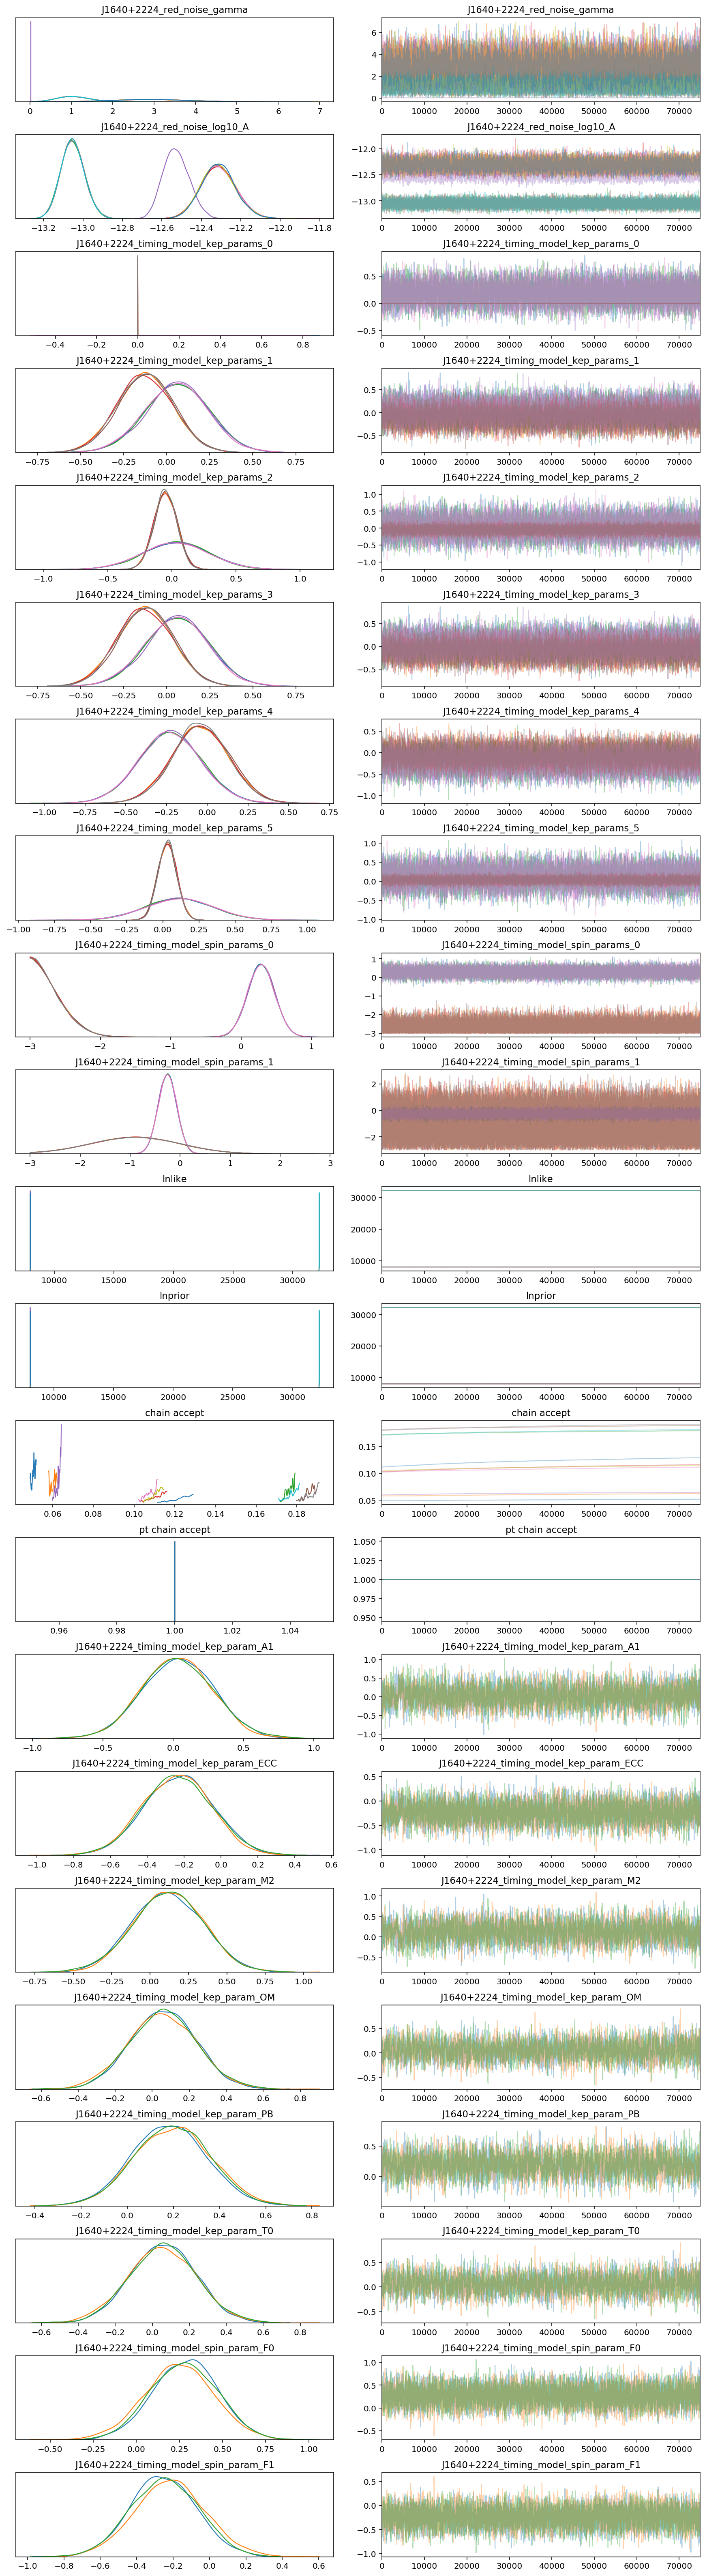

In [21]:
az.plot_trace(az_comb);

In [22]:
#indices = [8,16]
indices = [1,len(chain_list)]
rescaled_chain_dict = rescale_pars(chain_list,
                                   tmparam_list,pardict)

(11, 74925, 14)
(11, 14)


In [23]:
az_comb_rescaled = az.convert_to_inference_data(rescaled_chain_dict)

In [24]:
az.summary(az_comb_rescaled)

mean         sd     hpd_3%    hpd_97%  \
J1640+2224_red_noise_gamma        1.985      1.290      0.016      4.061   
J1640+2224_red_noise_log10_A    -12.601      0.354    -13.143    -12.184   
PB                              175.461      0.000    175.461    175.461   
T0                            52774.649   1519.283  51626.180  54784.471   
A1                               55.330      0.000     55.330     55.330   
OM                               50.732      0.001     50.731     50.733   
ECC                               0.001      0.000      0.001      0.001   
M2                                0.351      0.127      0.240      0.535   
F0                              316.124      0.000    316.124    316.124   
F1                               -0.000      0.000     -0.000     -0.000   
lnlike                        16805.057  11661.572   7985.527  32234.974   
lnprior                       16823.077  11661.918   8002.626  32253.618   
chain accept                      0.123      0.050      0.050      0.189   
pt chain accept                   1.000      0.000      1.000      1.000   

                              mcse_mean   mcse_sd  ess_mean    ess_sd  \
J1640+2224_red_noise_gamma        0.324     0.234      16.0      16.0   
J1640+2224_red_noise_log10_A      0.104     0.076      12.0      11.0   
PB                                0.000     0.000      11.0      11.0   
T0                              458.057   332.893      11.0      11.0   
A1                                0.000     0.000      16.0      16.0   
OM                                0.000     0.000      11.0      11.0   
ECC                               0.000     0.000      11.0      11.0   
M2                                0.038     0.028      11.0      11.0   
F0                                0.000     0.000      11.0      11.0   
F1                                0.000     0.000  824164.0  824164.0   
lnlike                         3515.909  2555.186      11.0      11.0   
lnprior                        3516.013  2555.262      11.0      11.0   
chain accept                      0.015     0.011      11.0      11.0   
pt chain accept                   0.000     0.000  824164.0  824164.0   

                              ess_bulk  ess_tail  r_hat  
J1640+2224_red_noise_gamma        16.0      11.0   1.83  
J1640+2224_red_noise_log10_A      16.0     133.0   1.78  
PB                                18.0     135.0   1.62  
T0                                18.0     134.0   1.62  
A1                                19.0     135.0   1.55  
OM                                18.0     139.0   1.62  
ECC                               18.0     136.0   1.62  
M2                                18.0     138.0   1.62  
F0                                18.0      81.0   1.65  
F1                                18.0     122.0   1.63  
lnlike                            16.0      99.0   1.83  
lnprior                           15.0      36.0   1.95  
chain accept                      11.0      12.0   6.94  
pt chain accept               824164.0  824164.0    NaN

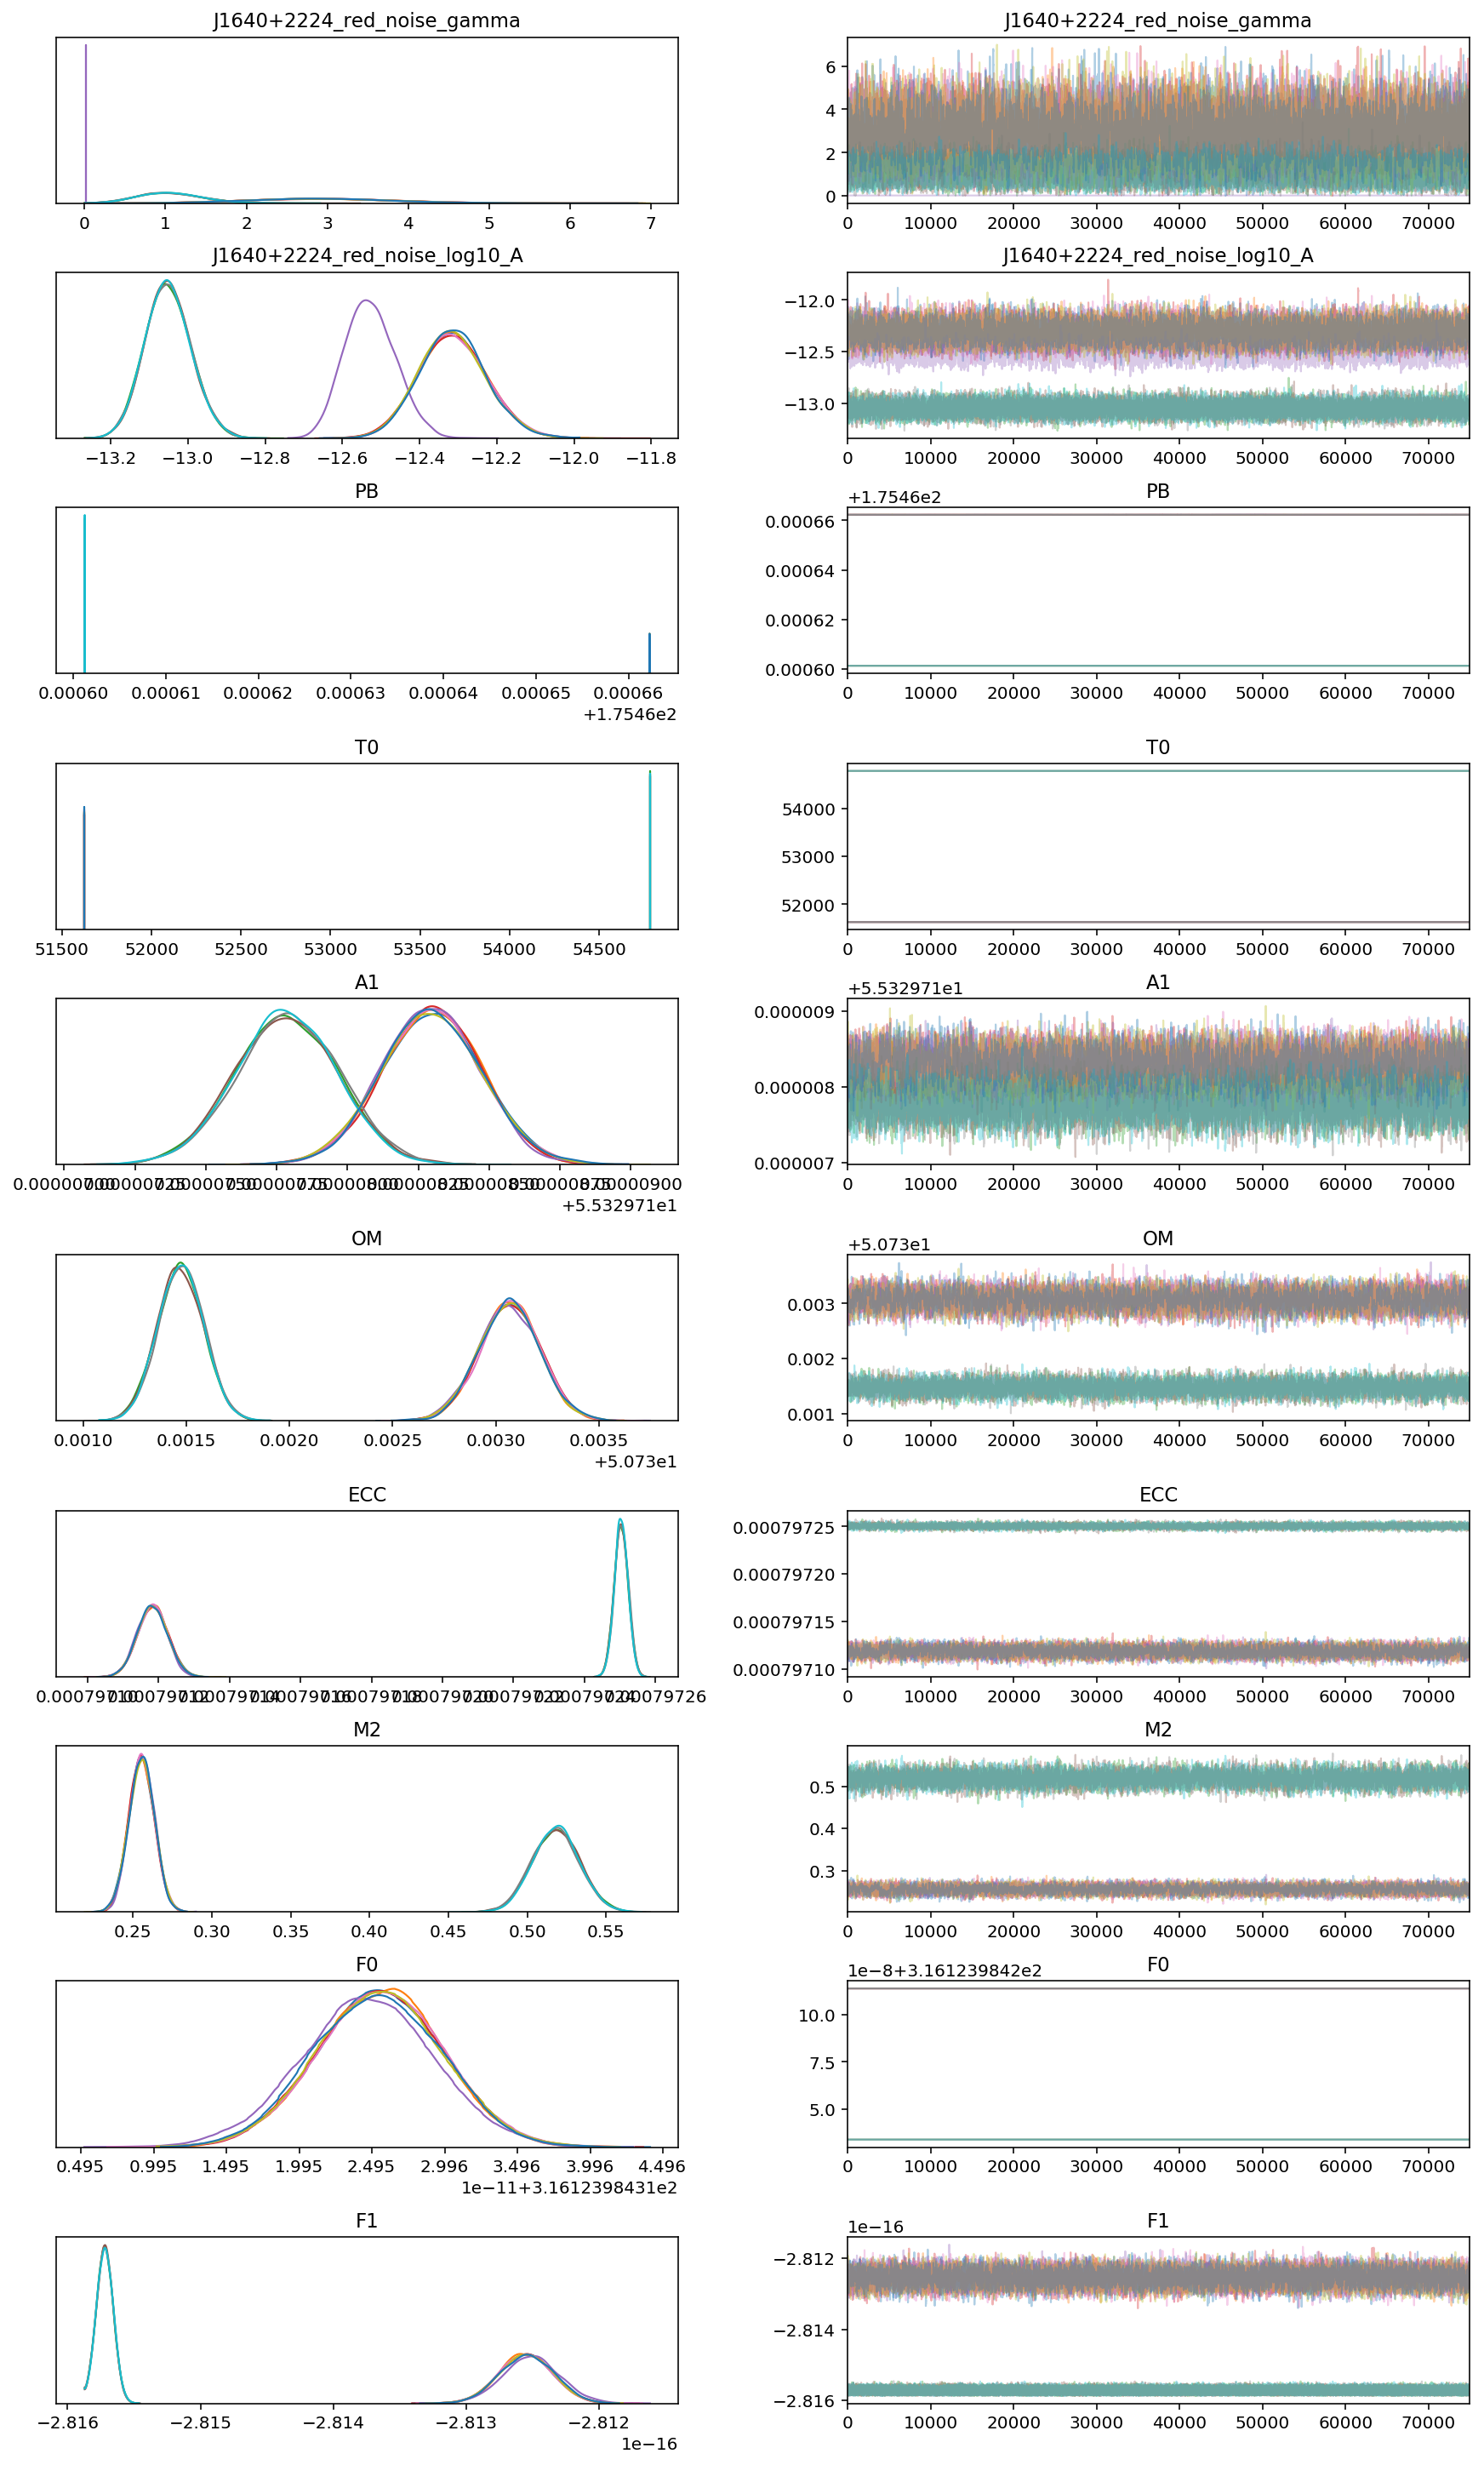

In [25]:
common_pars = []
for param in rescaled_chain_dict.keys():
    if param not in ['lnlike','lnprior', 'chain accept', 'pt chain accept']:
        common_pars.append(param)
az.plot_trace(az_comb_rescaled,var_names=common_pars);